# Import Packages

In [131]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

# keras has the mnist data set built in
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import Input, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D

from keras.models import Model
from keras.utils import np_utils

# visualization tools
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from kt_utils import *
%matplotlib inline

# Load Data

In [132]:
# split train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)
print(y_train[4])

X_train original shape (60000, 28, 28)
y_train original shape (60000,)
9


## Visualize Data

3


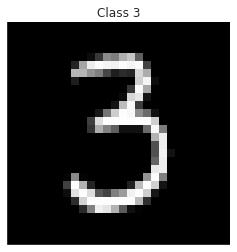

In [133]:
# Training sample
m = 50# try changing
plt.imshow(X_train[m], cmap='gray', interpolation='none')
plt.title("Class {}".format(y_train[m]))
plt.xticks([])
plt.yticks([])
print(y_train[m])

## Prepare and Normalize 

In [135]:
X_train_flat = X_train.reshape(60000, 784).astype('float32') # flatten image to row vector
X_test_flat = X_test.reshape(10000, 784).astype('float32')
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalize
X_train /= 255
X_test /= 255
X_train_flat /= 255
X_test_flat /= 255
print("Training shape flat", X_train_flat.shape)
print("Testing shape flat", X_test_flat.shape)
print("Original", X_train.shape)

Training shape flat (60000, 784)
Testing shape flat (10000, 784)
Original (60000, 28, 28)


### Convert Labels to One-Hot encodings

In [141]:
nb_classes = 10

# notice big Y - storing different name variable for hot encoding
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

print("Label matrix shape: ", Y_train.shape)
print("Label matrix shape: ", Y_test.shape)
print(Y_train[m,:])

Label matrix shape:  (60000, 10)
Label matrix shape:  (10000, 10)
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


<hr>
# Construct Neural Network

## 4 steps to build NN in Keras

<b>1) Construct computational graph </b><br>
2) Compile <br>
3) Train <br>
4) Predict <br>
<br>
Lets make 3 different models: 
    - Two Identical Models declared differently
    - Convolutional model

In [159]:
# Sequential model
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu')) 
                           
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax')) 

In [ ]:
# Functional API - more complex models - allows multiple types of inputs and outputs

# tensor input placeholder with shape input_shape
X_input = Input(shape=X_train_flat.shape[1:])

# Layer 1
X = Dense(512, name='fc0')(X_input)
X = Activation('relu')(X)
    
# Layer 2
X = Dense(512, name='fc1')(X)
X = Activation('relu')(X)
    
#Layer 3 - output
X = Dense(10, name='fc2')(X)
X = Activation('softmax')(X)
    
FCmodel = Model(inputs=X_input, outputs=X, name='FC_Model')

In [170]:
# Convolutional Network

X_in = Input(shape=(28,28,1))
    
X2 = ZeroPadding2D((1,1))(X_in)
    
# CONV -> BN -> RELU Block applied to X
X2 = Conv2D(32, (3, 3), strides=(1, 1), name='conv0')(X2)
X2 = BatchNormalization(axis=2, name='bn0')(X2)
X2 = Activation('relu')(X2)

# MAXPOOL
X2 = MaxPooling2D((2, 2), name='max_pool')(X2)

# Flatten X + fully connected
X2 = Flatten()(X2)
X2 = Dense(10, activation='softmax', name='fc')(X2)

# Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
ConvModel = Model(inputs=X_in, outputs=X2, name='Conv_MNIST')

In [171]:
# print summary of sequential model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 512)               401920    
_________________________________________________________________
activation_81 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_82 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 10)                5130      
_________________________________________________________________
activation_83 (Activation)   (None, 10)                0         
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [172]:
FCmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 784)               0         
_________________________________________________________________
fc0 (Dense)                  (None, 512)               401920    
_________________________________________________________________
activation_84 (Activation)   (None, 512)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               262656    
_________________________________________________________________
activation_85 (Activation)   (None, 512)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 10)                5130      
_________________________________________________________________
activation_86 (Activation)   (None, 10)                0         
Total para

In [173]:
ConvModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
zero_padding2d_12 (ZeroPaddi (None, 30, 30, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 28, 28, 32)        112       
_________________________________________________________________
activation_88 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 6272)              0         
__________

In [174]:
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

### 2) Compile

Choose loss function and optimizer

In [175]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
FCmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ConvModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 3) Train

In [ ]:
# Train Sequential model first
history = model.fit(X_train_flat, Y_train, epochs=3, validation_data=(X_test_flat, Y_test))

print("History output:")
print(history.history)

In [176]:
# Train Conv model
histroy2 = ConvModel.fit(X_train.reshape(60000,28,28,1), Y_train, epochs=3)

Epoch 1/3
60000/60000 [==============================] - 409s 7ms/step - loss: 0.4784 - acc: 0.8592
Epoch 2/3
60000/60000 [==============================] - 374s 6ms/step - loss: 0.2590 - acc: 0.9254
Epoch 3/3
 4160/60000 [=>............................] - ETA: 6:02 - loss: 0.2286 - acc: 0.9349

KeyboardInterrupt: 

In [ ]:
# visualize Cost vs. Iterations as I am training
# use ggplot style ()
plt.style.use('seaborn-notebook')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Cost vs Iterations', size=24)
plt.ylabel('Cost', size=20)
plt.xlabel('Iteration', size=20)
plt.legend(['Train', 'Test'])

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy vs Iterations', size=24)
plt.ylabel('Cost', size=20)
plt.xlabel('Iteration', size=20)
plt.legend(['Train', 'Test'], loc='lower right')

### Evaluate

In [ ]:
Cost, Acc = model.evaluate(X_test_flat, Y_test)
print(Cost)
print(Acc)
# print('Test score:', score[0])
# print('Test accuracy:', score[1])

# Predict

Try with Another Image

(-0.5, 27.5, 27.5, -0.5)

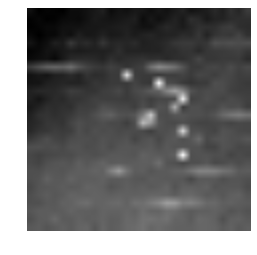

In [108]:
from keras.preprocessing import image
import PIL.ImageOps

img_path = 'Three.jpg'
#Read image + resize
img = image.load_img(img_path, target_size=(28, 28))

# Convert to graysclae and take inverse. MNIST recognizes bright foreground with dark background
img = img.convert('L')

#Display image
plt.imshow(img)
plt.grid('off')
plt.axis('off')

In [106]:
from keras.applications.imagenet_utils import preprocess_input

x = image.img_to_array(img).reshape(1,784)

print(np.argmax(model.predict(x)))

7


## Topics for next week ???

<ul>
    <li>Transfer Learning
    <li>Convolutional Neural Nets
    <li>Tesnorflow tutorial
    <li>Bias Variance
    <li>Someone's research 
</ul>

## Acknowledgment

Most of this material was written by Xavier Snelgrove <br>
https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb
<br><br>

Also Available from my github - https://github.com/AdamRauff/Deep-Learning